In [33]:
import numpy as np
from scipy.ndimage import sobel, laplace, convolve, gaussian_filter
from scipy.ndimage.interpolation import shift
from scipy.sparse import lil_matrix
import pyamg

In [34]:
def calc_residual(delta_flow: np.ndarray) -> float:
    return np.sum(np.real(delta_flow @ delta_flow.conj().T)) / delta_flow.size


def calc_edge_map(org: np.ndarray, sigma=3) -> np.ndarray:
    blur = gaussian_filter(org, sigma=sigma)
    return sobel(blur, axis=1, mode="mirror") + 1j * sobel(blur, axis=0, mode="mirror")


def calc_flow(edge_map: np.ndarray) -> np.ndarray:
    return sobel(np.real(edge_map), axis=1, mode="mirror") + 1j * sobel(
        np.imag(edge_map), axis=0, mode="mirror"
    )

def convolve_flow(cimg: np.ndarray, ckernel: np.ndarray) -> np.ndarray:
    ret_real = convolve(np.real(cimg), np.real(ckernel))
    ret_imag = convolve(np.imag(cimg), np.imag(ckernel))
    return  ret_real + 1j * ret_imag

def calc_gvf(
    edge_map: np.ndarray,
    sigma=3,
    mu: float = 0.2,
    max_iter: int = 1024,
    conv_criteria: float = 1e-2,
) -> np.ndarray:
    init_flow = calc_flow(edge_map)
    init_power = init_flow * init_flow.conj()

    flow = init_flow
    for i in range(max_iter):
        laplace_flow = laplace(np.real(flow), mode="mirror") + 1j * laplace(
            np.imag(flow), mode="mirror"
        )
        delta_flow = mu * laplace_flow - init_power * (flow - init_flow)
        residual = calc_residual(delta_flow)
        if residual < conv_criteria:
            break

        flow += delta_flow
    return flow


def _calc_vector_field_kernel(
    half_kernel: int, radius: float, gamma: float = 2
) -> np.ndarray:
    flow_x, flow_y = np.meshgrid(
        range(-half_kernel, half_kernel + 1, 1), range(-half_kernel, half_kernel + 1, 1)
    )
    flow = flow_x + 1j * flow_y
    dist = np.abs(flow)
    magnitude = np.power((dist + 1e-7), -gamma)
    magnitude[radius < dist] = 0
    return magnitude * flow


def calc_vfc(
    edge_map: np.ndarray,
    sigma: float = 3.0,
    half_kernel: int = 31,
    radius: float = 30,
    gamma=1,
) -> np.ndarray:
    flow_kernel = _calc_vector_field_kernel(half_kernel, radius, gamma)
    return convolve_flow(edge_map, flow_kernel)

In [35]:
def _calc_gradient_field_kernel() -> np.ndarray:
    return 0.25 * np.array([[0, 1 + 1j, 0], [1 + 1j, 0, 1 + 1j], [0, 1 + 1j, 0]])


def _calc_mask(flow: np.ndarray):
    power = flow * flow.conj()
    return power < 1e-7


def calc_gfc(edge_map: np.ndarray) -> np.ndarray:
    init_flow = calc_flow(edge_map)
    mask = _calc_mask(init_flow)
    flow_kernel = _calc_gradient_field_kernel()

    flow = init_flow
    delta_flow = 1j * np.zeros_like(flow)
    for _ in range(1024):
        next_flow = convolve_flow(flow, flow_kernel)
        if np.max(np.abs(flow[mask] - next_flow[mask])) < 1e-7:
            break
        flow[mask] = next_flow[mask]

    return flow

In [36]:
def _calc_neighbor_indice(index):
    return np.stack(
        [
            shift(index, s, cval=-2)[0 <= index]
            for s in [[0, 0], [0, 1], [0, -1], [1, 0], [-1, 0]]
        ],
        axis=1,
    )


def _calc_linear_equation_mat(
    flow_map: np.ndarray, neighbor_indice: np.ndarray, offset: np.ndarray
):

    rows = neighbor_indice[:, 0]
    n_rows = neighbor_indice.shape[0]
    A = lil_matrix((n_rows, n_rows))
    b = np.zeros((n_rows, 1))

    w = flow_map.shape[1]
    flatten_flow_map = flow_map.flatten()
    A[rows, rows] = np.broadcast_to(4, (n_rows,))
    for neighbors, d in zip(neighbor_indice[:, 1:].T, [-1, 1, -w, w]):
        a_rows = rows[0 <= neighbors]
        a_cols = neighbors[0 <= neighbors]
        b_rows = rows[-1 == neighbors]
        b[b_rows, 0] = flatten_flow_map[offset[b_rows] + d]
        A[a_rows, a_cols] = -1

    B = np.ones((A.shape[0], 1))
    return A.tocsr(), B, b


def _calc_offset(mask: np.ndarray, index: np.ndarray):
    offset = np.arange(index.shape[0] * index.shape[1]).reshape(*index.shape)
    offset[mask == False] = -1
    return offset[0 <= index]


def _calc_index(mask: np.ndarray):
    index = np.cumsum(mask).reshape(*edge_map.shape) - 1
    index[mask == False] = -1
    return index


def _calc_gf(flow_map: np.ndarray):
    mask = _calc_mask(flow_map)
    index = _calc_index(mask)
    offset = _calc_offset(mask, index)
    neighbor_indice = _calc_neighbor_indice(index)

    A, B, b = _calc_linear_equation_mat(flow_map, neighbor_indice, offset)
    ml = pyamg.smoothed_aggregation_solver(A, B, max_coarse=10)
    x = ml.solve(b=b, x0=np.random.rand(A.shape[0], 1), tol=1e-9)

    delta = np.zeros_like(flow_map).flatten()
    delta[offset] = x
    delta = delta.reshape(*flow_map.shape)
    return flow_map + delta


def calc_gf(flow_map: np.ndarray):
    init_flow = calc_flow(edge_map)
    return _calc_gf(np.real(init_flow)) + 1j * _calc_gf(np.imag(init_flow))

In [37]:
from skimage import data, io, feature

In [38]:
org = data.camera().astype(np.float32)
edge_map = calc_edge_map(org)

In [39]:
flow_gvf = calc_gvf(edge_map)
flow_vfc = calc_vfc(edge_map)
flow_gf = calc_gf(edge_map)
flow_gfc = calc_gfc(edge_map)

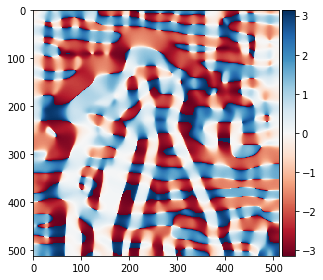

In [40]:
io.imshow(np.angle(flow_gvf))

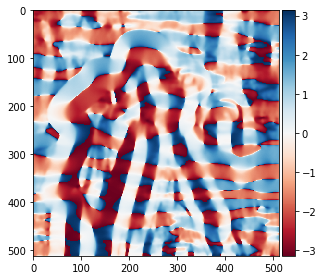

In [41]:
io.imshow(np.angle(flow_vfc))

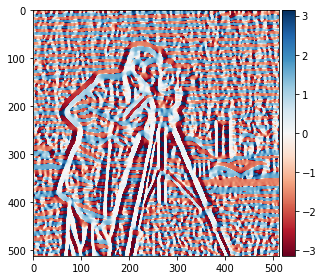

In [42]:
io.imshow(np.angle(flow_gfc))

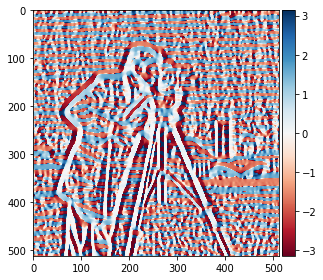

In [43]:
io.imshow(np.angle(flow_gf))